In [4]:
%matplotlib inline
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from math import sqrt, pi

# 🔐 Grover’s Algorithm – Cryptographic Key Search

## 1️⃣ Problem Definition
Given a known plaintext–ciphertext (or hash) pair:

$$
E_k(m) = c
\quad \text{or} \quad
h(k) = y
$$

Goal: find the unknown key $k$.

**Classical brute-force:**
$$
O(2^n) \text{ key checks}
$$

**Grover’s quantum search:**
$$
O(2^{n/2}) \text{ oracle calls}
$$

---

## 2️⃣ Quantum Representation
Each possible key is an $n$-qubit basis state:
$$
|k\rangle = |k_{n-1}k_{n-2}\dots k_0\rangle
$$

The register initially holds a **uniform superposition**:
$$
|s\rangle = \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1}|k\rangle
$$

---

## 3️⃣ Oracle Construction
The oracle marks the **correct key** by flipping its phase:

$$
O|k\rangle =
\begin{cases}
-|k\rangle, & \text{if } f(k)=1 \text{ (correct key)}\\
|k\rangle, & \text{otherwise}
\end{cases}
$$

In cryptographic context:
- $f(k) = 1$ if $E_k(m) = c$
- Implemented reversibly using:
  - Encryption circuit  
  - Comparator (to check equality)  
  - Controlled-$Z$ phase flip on success

---

## 4️⃣ Diffusion Operator
Reflects the amplitudes about their average.

$$
D = 2|s\rangle\langle s| - I
$$

Implementation pattern (for $n$ qubits):
1. Apply **Hadamard** on all qubits  
2. Apply **X** on all qubits  
3. Apply **multi-controlled Z** (H–MCX–H trick)  
4. Apply **X** on all qubits  
5. Apply **Hadamard** on all qubits

---

## 5️⃣ Grover Iterations
Each iteration performs a **rotation** by angle $2\theta$ toward the marked state.

$$
G = D \cdot O
$$

After $r$ iterations:
$$
|\psi_r\rangle = G^r|s\rangle
$$

Optimal number of iterations:
$$
r \approx \frac{\pi}{4}\sqrt{\frac{N}{M}}
$$

where  
$N = 2^n$ → total keys  
$M$ → number of correct keys (usually $M=1$).

---

## 6️⃣ Measurement
After the iterations, measuring the register yields the **correct key** with high probability.

$$
P_r = \sin^2((2r+1)\theta)
$$

---

## 7️⃣ Cryptographic Implications

| Scheme | Classical Complexity | Quantum (Grover) | Security Impact |
|:-------:|:-------------------:|:----------------:|:----------------|
| AES-128 | $2^{128}$ | $2^{64}$ | Halves key strength |
| AES-256 | $2^{256}$ | $2^{128}$ | Safe for post-quantum |
| SHA-256 (preimage) | $2^{256}$ | $2^{128}$ | Double hash size needed |

---

## 8️⃣ Key Insights
- Grover doesn’t *break* symmetric cryptography — it **reduces the effective key length by half**.  
- To stay secure against quantum attacks, **double symmetric key lengths**.  
- For asymmetric crypto (RSA, ECC), **Shor’s algorithm** is the real threat.  
- Grover’s principle underlies many subroutines like **quantum amplitude estimation** and **quantum counting**.

---

## 9️⃣ Summary
| Step | Description |
|------|--------------|
| 1 | Prepare uniform superposition over all keys |
| 2 | Oracle flips phase of correct key |
| 3 | Diffusion amplifies its amplitude |
| 4 | Repeat $r \approx \frac{\pi}{4}\sqrt{N}$ times |
| 5 | Measure and obtain the correct key with high probability |

---

**End result:**
$$
O(2^{n/2}) \text{ query complexity} \quad \text{vs.} \quad O(2^n) \text{ classically.}
$$

**Practical takeaway:**  
Use AES-256 and 256-bit hashes to stay safe in the quantum era.


In [11]:
def buildOracleCircuit(target:str) -> QuantumCircuit:
    n = len(target)
    oracleCircuit = QuantumCircuit(n,name=f'    0racle_{target}')

    # Apply X gates to qubits corresponding to '0's in the target bitstring
    zeros = [i for i, bit in enumerate(reversed(target)) if bit == '0']
    if zeros:
        oracleCircuit.x(zeros)

    # Apply multi-controlled Z gate
    target = n-1
    controls = list(range(n-1))
    oracleCircuit.h(target)
    oracleCircuit.mcx(controls,target)
    oracleCircuit.h(target)

    # Apply X gates again to revert the earlier transformation
    if zeros:
        oracleCircuit.x(zeros)

    print(f"Oracle Circuit for target '{target}':")
    oracleCircuit.draw('mpl')

    return oracleCircuit.to_gate()

In [12]:
def buildReflectionCircuit(n:int) -> QuantumCircuit:
    reflectionCircuit = QuantumCircuit(n,name=f"    reflection_{n}")

    # Apply Hadamard and X gates to all qubits
    reflectionCircuit.h(range(n))
    reflectionCircuit.x(range(n))

    # Apply multi-controlled Z gate
    target = n-1
    controls = list(range(n-1))
    reflectionCircuit.h(target)
    reflectionCircuit.mcx(controls,target)
    reflectionCircuit.h(target)

    # Apply X and Hadamard gates again to revert the earlier transformation
    reflectionCircuit.x(range(n))
    reflectionCircuit.h(range(n))

    print(f"Reflection Circuit for {n} qubits:")
    reflectionCircuit.draw('mpl')

    return reflectionCircuit.to_gate()

Oracle Circuit for target '2':
Reflection Circuit for 3 qubits:
Number of iterations: 2


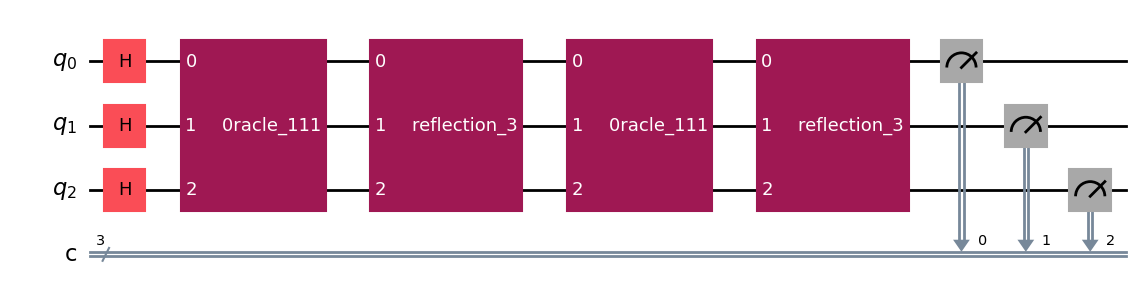

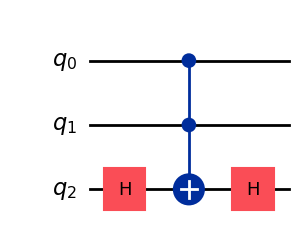

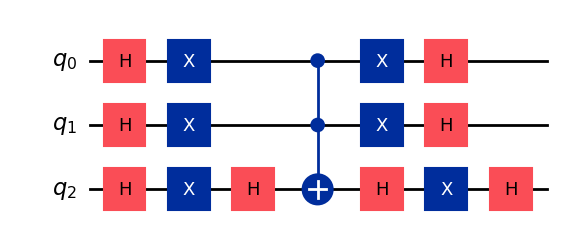

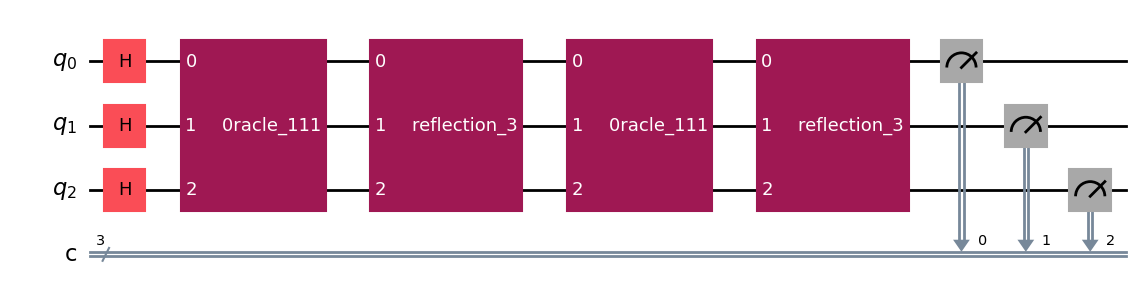

In [13]:
# demonstration for n=3 (8 possible keys)
# fake "hash" h(k) = (k+3) mod 8
# target output = 2

# oracle: mark key where (k+3)%8 = 2
# solutions: k where (k+3)%8 == 2 -> k == (2-3)%8 = 7
# 7 = 111 in binary, so lets flip |111> only

n = 3
N = 2**n
target = 2

oracleGate = buildOracleCircuit(target=format((target-3)%N, f'0{n}b'))
reflectionGate = buildReflectionCircuit(n)

iterations = round((pi/4)*sqrt(N/1))

print(f"Number of iterations: {iterations}")

groverCircuit = QuantumCircuit(n,n)
groverCircuit.h(range(n))
for _ in range(iterations):
    groverCircuit.append(oracleGate,range(n))
    groverCircuit.append(reflectionGate,range(n))

groverCircuit.measure(range(n),range(n))
groverCircuit.draw('mpl')

In [8]:
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)

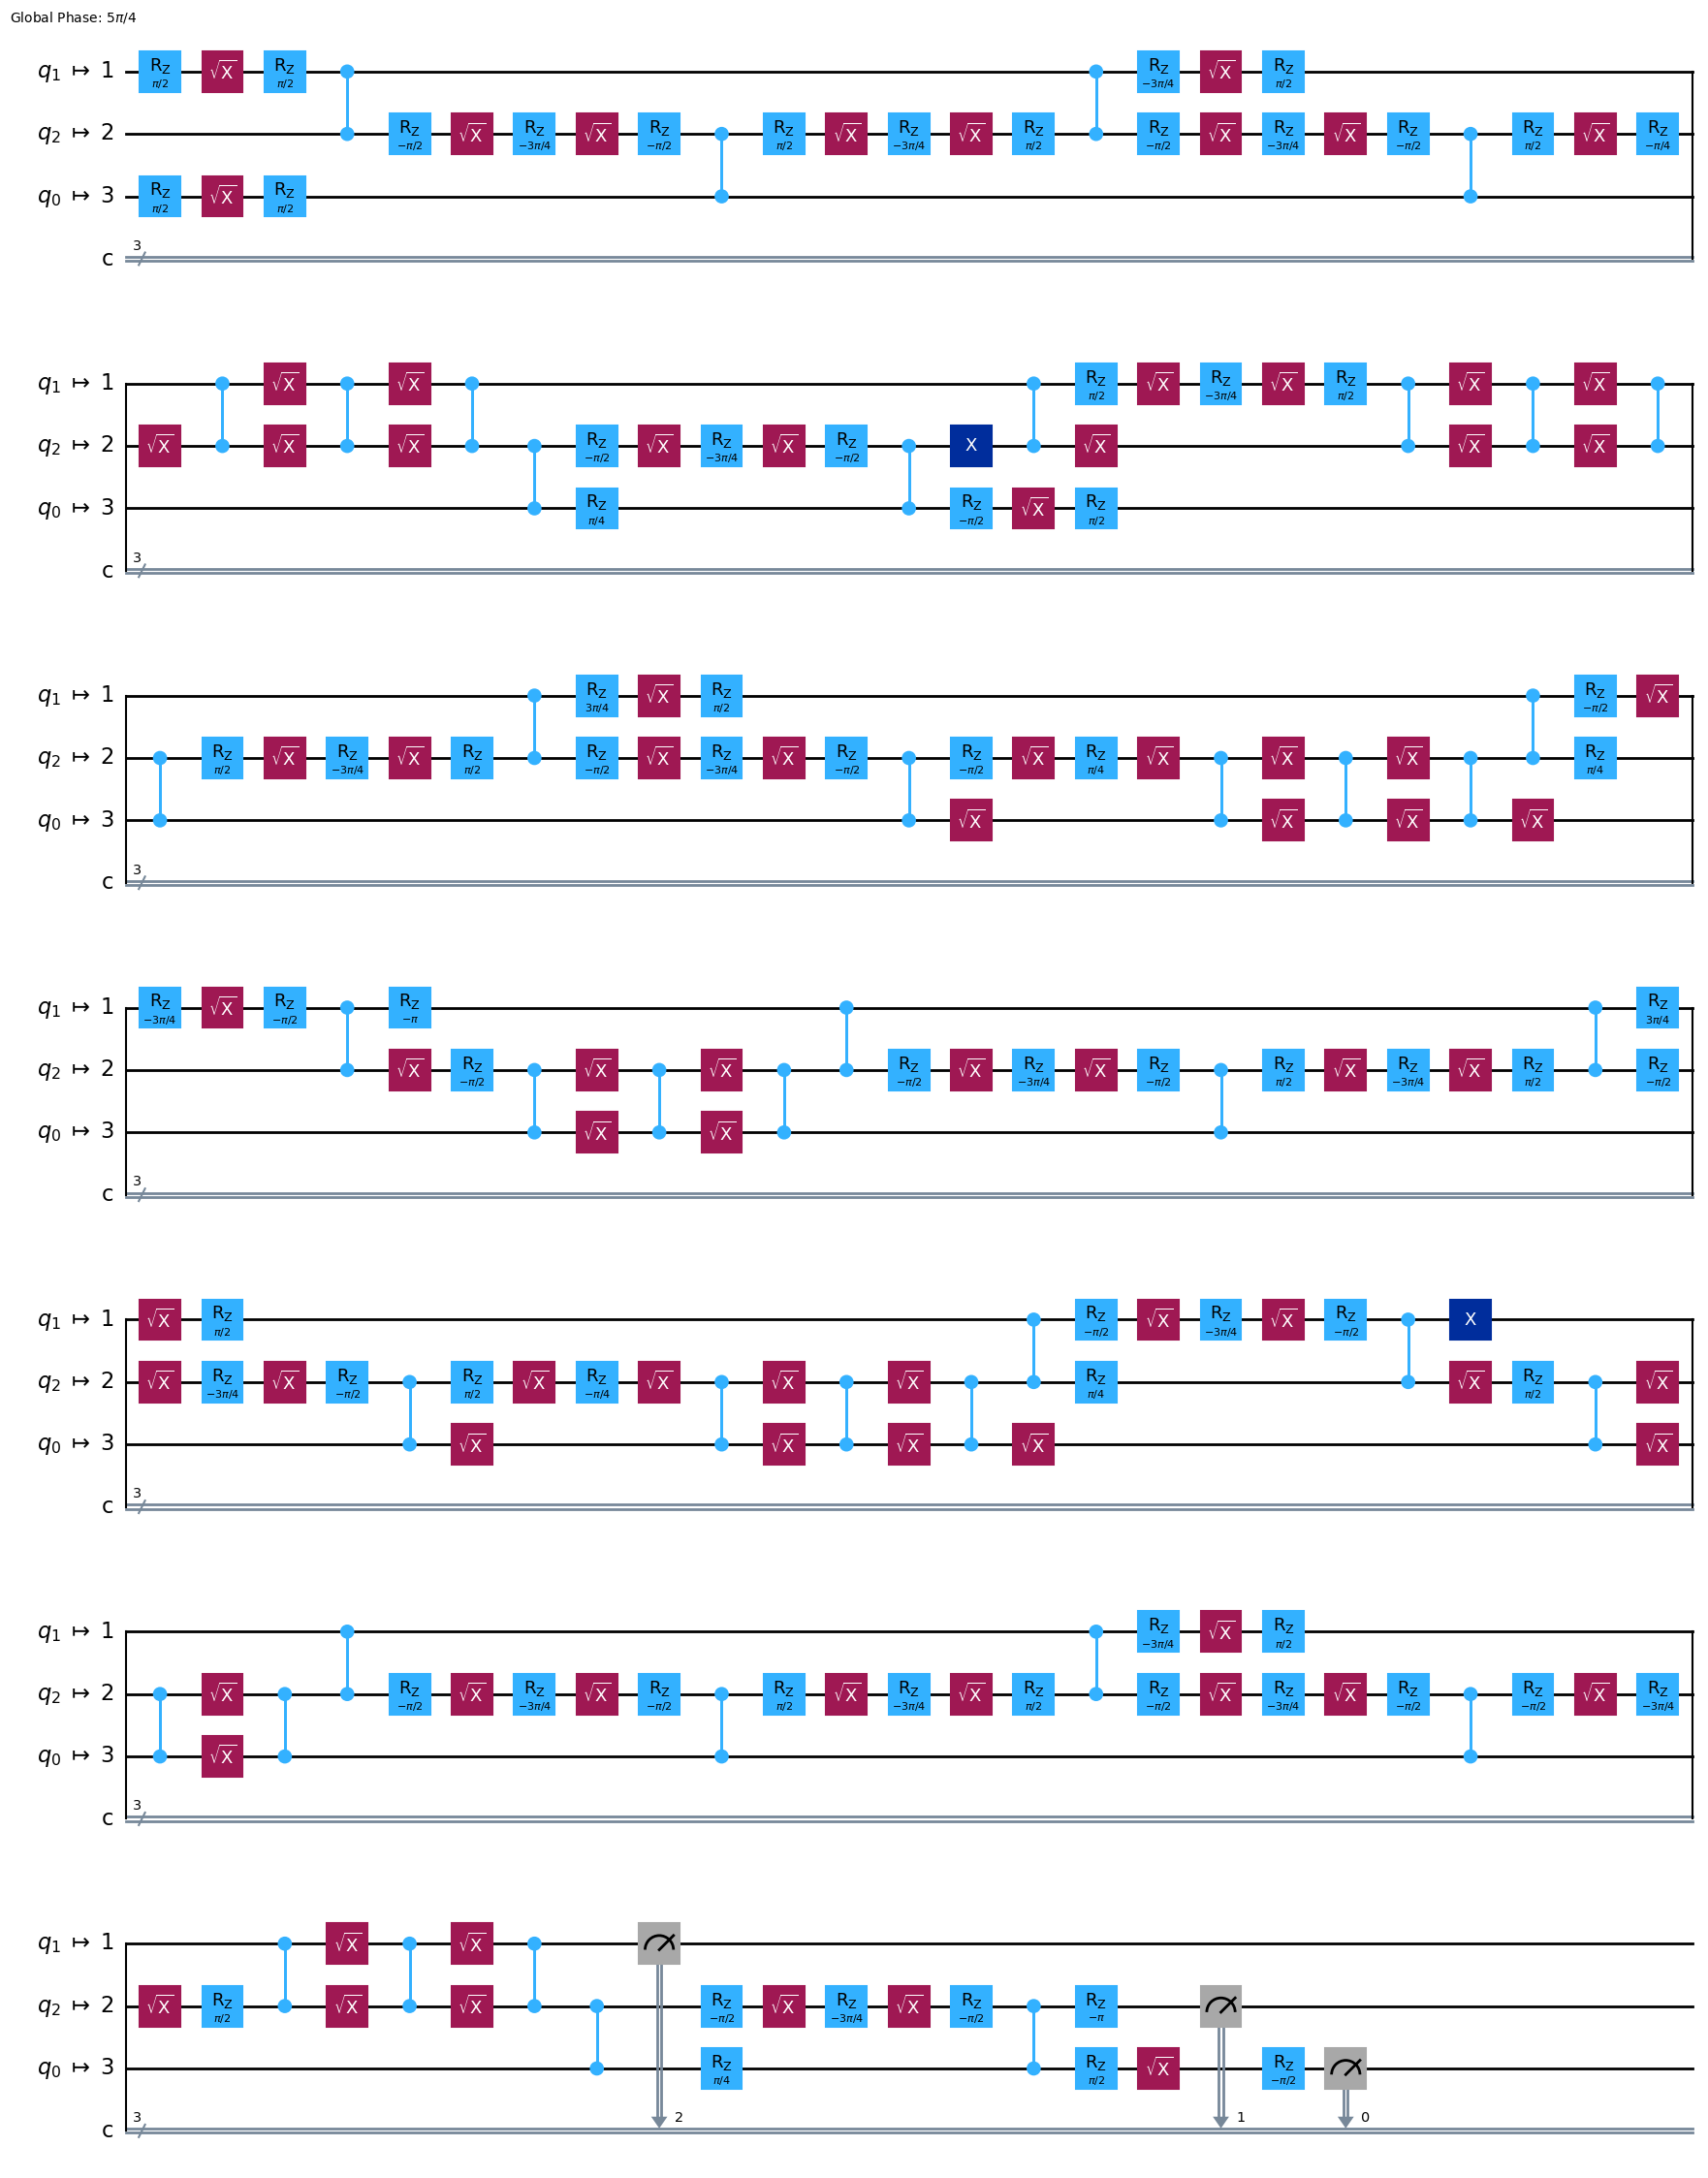

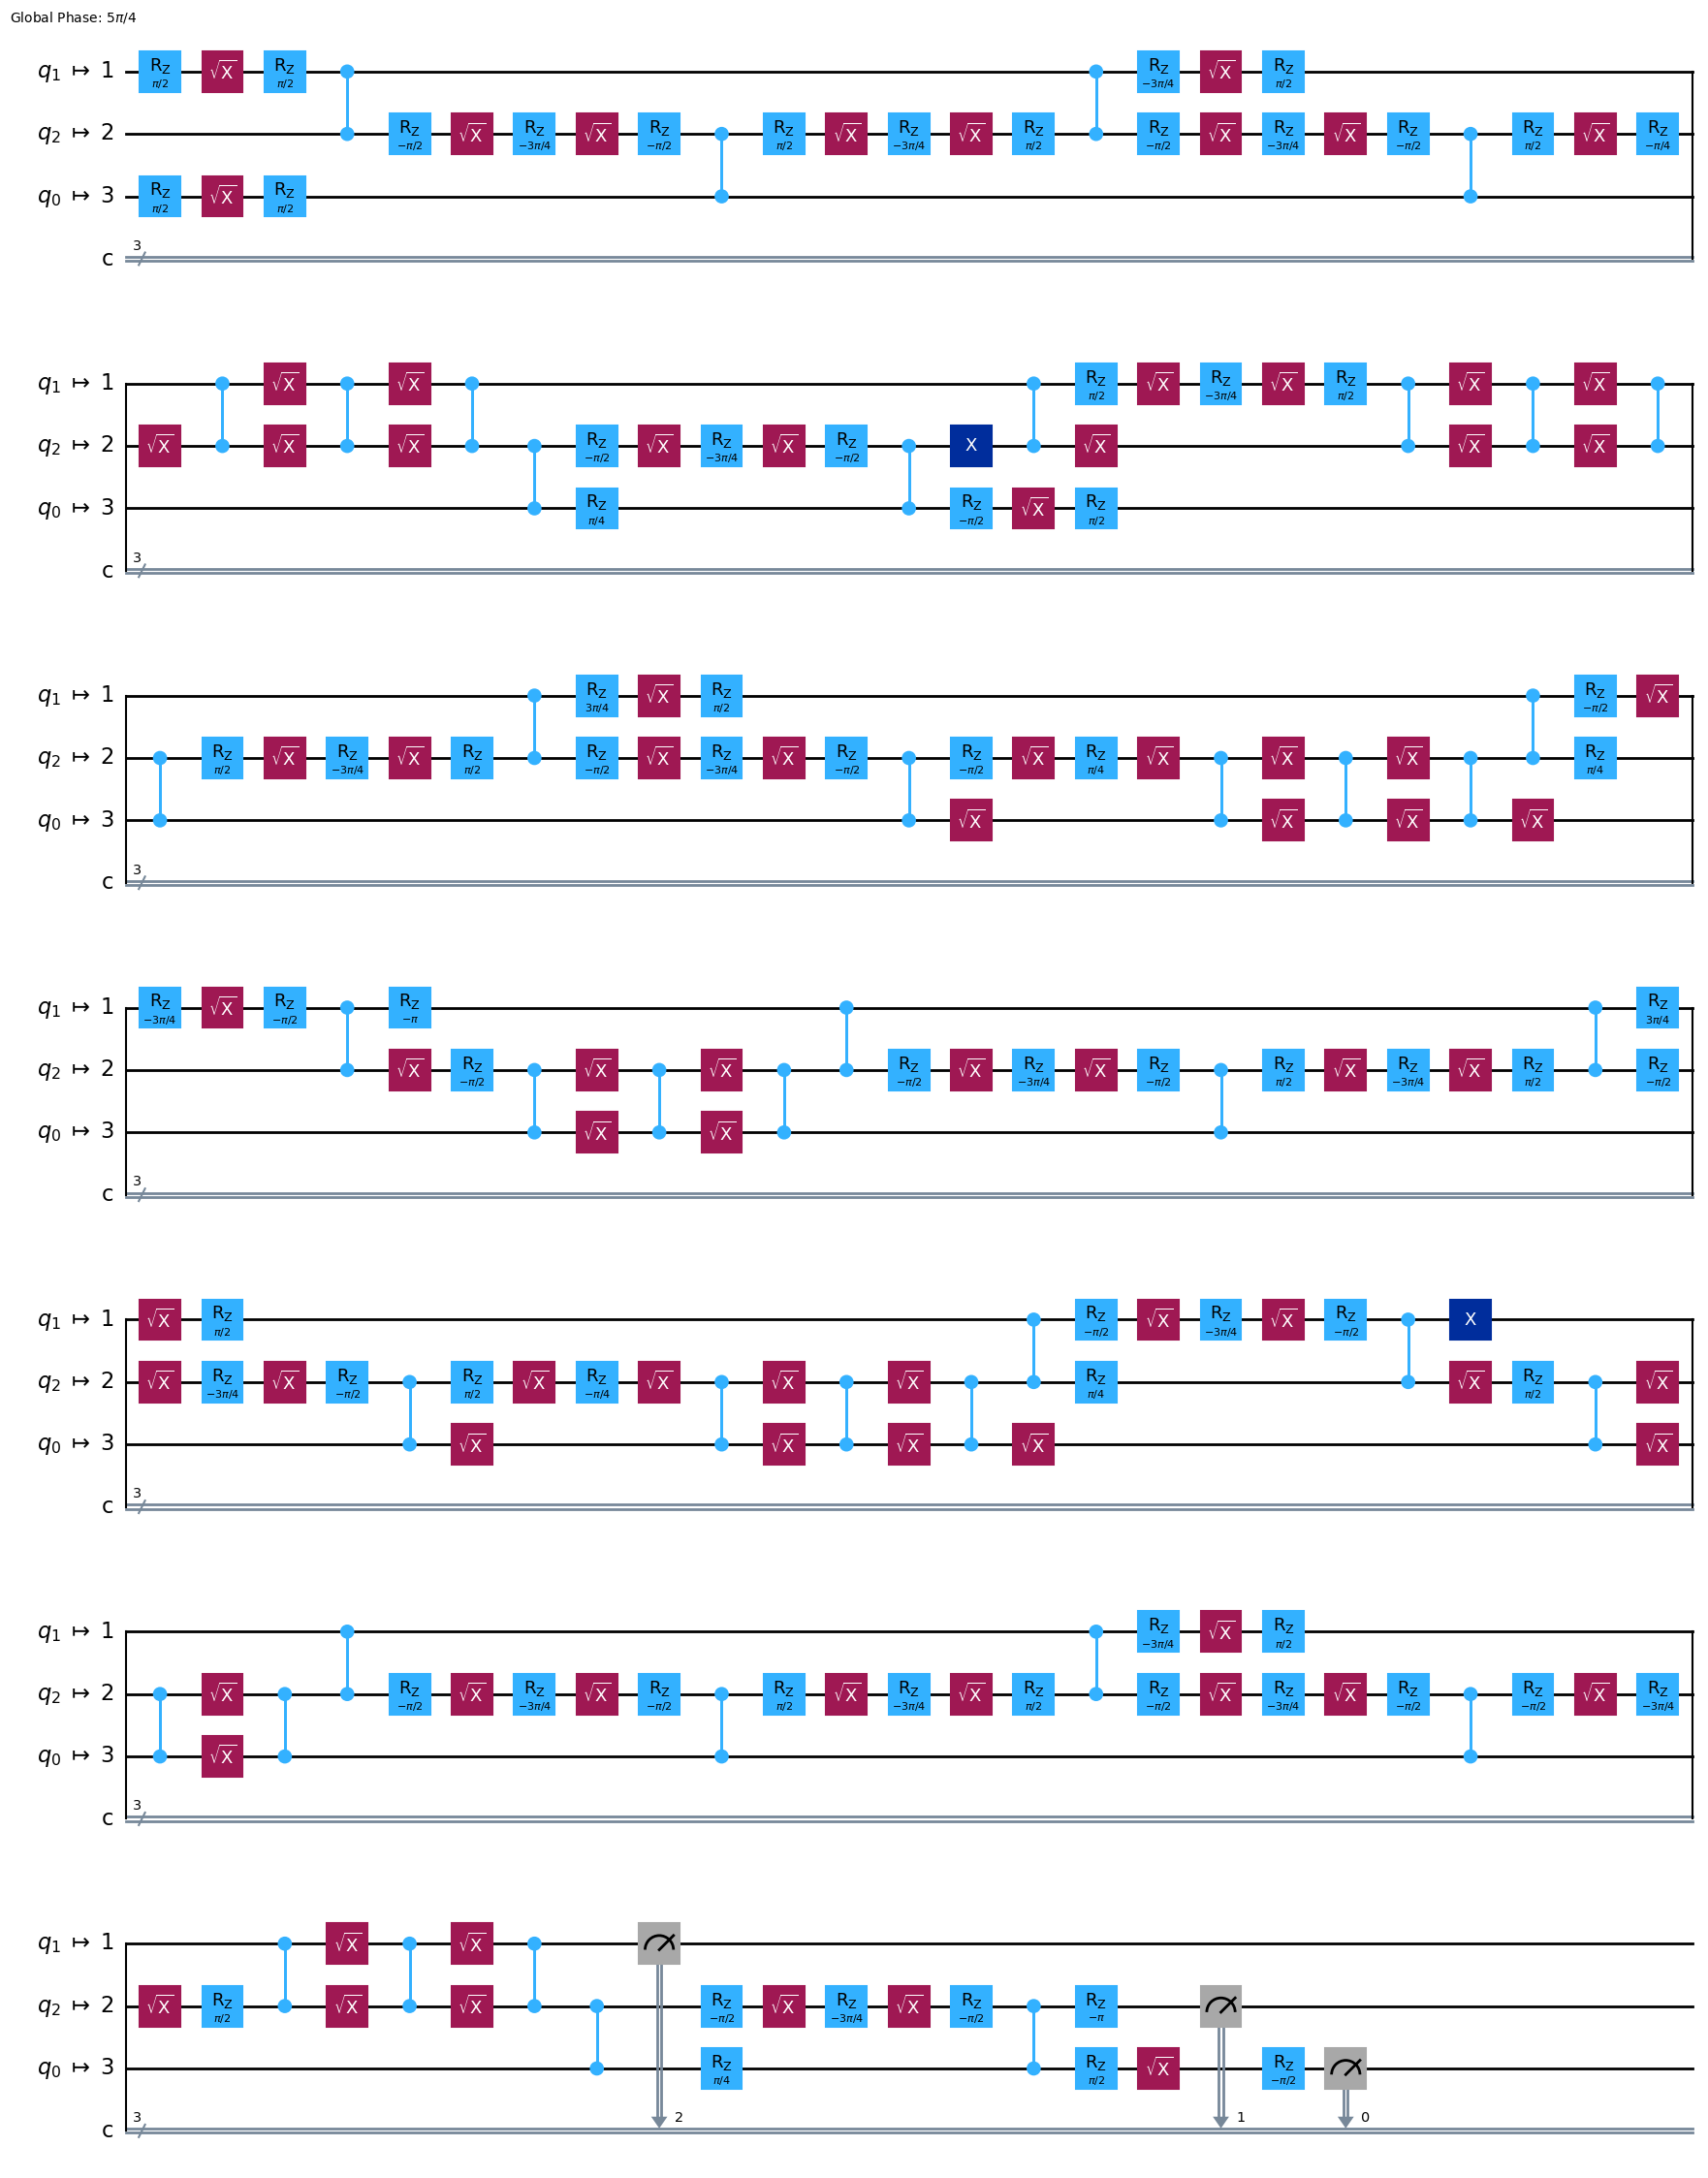

In [9]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(groverCircuit)
 
isa_circuit.draw("mpl", idle_wires=False)

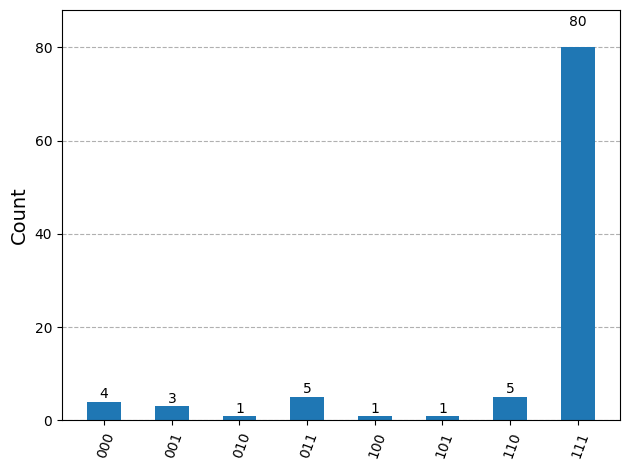

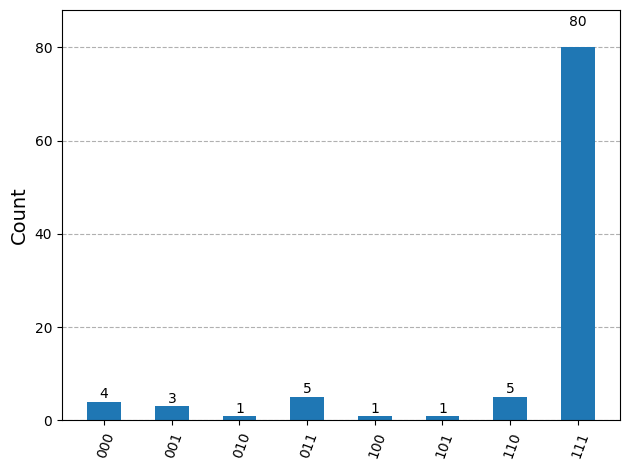

In [ ]:
sampler = Sampler(mode=backend)
jobSampler = sampler.run([isa_circuit], shots=100)
result = jobSampler.result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)

In [14]:

max_key = max(counts, key=counts.get)
print(f"Most probable key found: {max_key} with {counts[max_key]} counts with decimal value {int(max_key,2)}")

Most probable key found: 111 with 80 counts with decimal value 7


## 🔚 Conclusion

In our toy cryptographic experiment, the objective was to recover the unknown key \( k \) that satisfies the equation:

$$
h(k) = (k + 3) \bmod 8 = 2
$$

### 🔢 Possible Keys
Since \( n = 3 \) qubits, there are \( N = 2^3 = 8 \) possible keys:

| Decimal | Binary | Computed \( h(k) = (k+3) \bmod 8 \) |
|:--------:|:--------:|:----------------------------------:|
| 0 | 000 | 3 |
| 1 | 001 | 4 |
| 2 | 010 | 5 |
| 3 | 011 | 6 |
| 4 | 100 | 7 |
| 5 | 101 | 0 |
| 6 | 110 | 1 |
| 7 | 111 | 2 ✅ |

From this table, we can see that **only** the key \( k = 7 \) (binary **111**) produces the correct output \( h(k) = 2 \).

---

### 🧩 How Do We “Guess” the Correct Key?

- **Classical search:**  
  We must **try each key one by one**, compute \( h(k) \), and check whether it equals the target value.  
  This takes \( O(2^n) \) time — here, up to **8 tries**.

- **Quantum (Grover’s) search:**  
  Grover’s algorithm doesn’t “guess” sequentially — it evaluates **all keys simultaneously** in quantum superposition.  
  It uses interference to **amplify** the probability of the correct key and **suppress** the rest.  
  After about
  $$
  r \approx \frac{\pi}{4}\sqrt{N} = \frac{\pi}{4}\sqrt{8} \approx 2
  $$
  iterations, measuring the system yields the correct key with high probability — in this case, **|111⟩ (7)**.

---

### ✅ Result
The correct key is:

$$
k = 7 \; (111_2)
$$

Grover’s algorithm successfully identified it after only a few iterations, whereas a classical brute-force search would need to test every possible key.

---

### 💡 Interpretation
- The oracle was built to flip the phase of **|111⟩**, since it corresponds to the valid key.
- The diffuser then amplified the amplitude of that state.
- The histogram spike at **111** confirms that Grover’s search converged on the correct key.

---

### 🔐 Broader Insight
This small-scale example represents how Grover’s algorithm could be used for **cryptographic key recovery**:
- Classically, we would have to test **all possible keys or hashes**.
- Quantumly, we only need about **√N iterations**, giving a **quadratic speedup**.

While our experiment used only 3 qubits (8 possible keys), the same concept scales:  
for a 128-bit cipher (like AES-128), Grover would need roughly \( 2^{64} \) oracle calls — still massive, but half the classical effort.

---

### 🧠 Key Takeaway
Grover’s algorithm doesn’t “try” each key — it **amplifies** the correct one among all possibilities in parallel.  
This demonstrates how quantum search provides a fundamental speed advantage in cryptanalysis.
